In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
from scipy import stats
import ncar_jobqueue
from dask.distributed import Client

#### Define CESM case and get the years of data that we'll average over

In [5]:
variables = ['DIC','DIC_ALT_CO2','ALK','ALK_ALT_CO2'] 

### 2xGCB case 

In [14]:
case = 'cesm22cocco.G1850ECOIAF.T62_g17.003'
user = 'kristenk'
path = '/glade/campaign/cgd/oce/projects/besome/cesm-cases/' + case + '/ocn/proc/tseries/month_1'

In [15]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.024901-031012.nc'))       
  
    
    
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, chunks={'z_t' : 1})

    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading cesm22cocco.G1850ECOIAF.T62_g17.004
DIC


OSError: no files to open

In [5]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

In [6]:
# cluster = ncar_jobqueue.NCARCluster(project='ncgd0011')
# cluster.adapt(minimum_jobs=0, maximum_jobs=30)
# client = Client(cluster)
# client

In [7]:
#ds2xGCB=ds.mean(dim='time').compute()

In [8]:
outfile='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.004/ocn/proc/mean5thIAF/mean_IAF5_alk_dic.nc'
#ds2xGCB.to_netcdf(outfile)

In [9]:
ds2xGCB=xr.open_dataset(outfile,decode_times=False,decode_coords=False)

In [10]:
ds2xGCB

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t          (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m     (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT          (nlat, nlon) float64 ...
    TLONG        (nlat, nlon) float64 ...
    dz           (z_t) float32 ...
    TAREA        (nlat, nlon) float64 ...
    TLAT         (nlat, nlon) float64 ...
    REGION_MASK  (nlat, nlon) float64 ...
    ALK_ALT_CO2  (z_t, nlat, nlon) float32 ...
    ALK          (z_t, nlat, nlon) float32 ...
    DIC          (z_t, nlat, nlon) float32 ...
    DIC_ALT_CO2  (z_t, nlat, nlon) float32 ...

### GET noGCB ALK and DIC

In [11]:
case = 'cesm22cocco.G1850ECOIAF.T62_g17.003'
user = 'kristenk'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'

In [12]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.024901-031012.nc'))       
    
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, chunks={'z_t' : 1})

    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading cesm22cocco.G1850ECOIAF.T62_g17.003
ALK_ALT_CO2
ALK
DIC
DIC_ALT_CO2
CPU times: user 3.54 s, sys: 240 ms, total: 3.78 s
Wall time: 5.93 s


In [13]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

In [14]:
# cluster = ncar_jobqueue.NCARCluster(project='ncgd0011')
# cluster.adapt(minimum_jobs=0, maximum_jobs=30)
# client = Client(cluster)
# client

Client Scheduler: tcp://128.117.181.216:41289 Dashboard: https://jupyterhub.ucar.edu/dav/user/kristenk/proxy/39721/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [16]:
#dsnoGCB=ds.mean(dim='time').compute()

In [17]:
outfile='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.003/ocn/proc/mean5thIAF/mean_IAF5_alk_dic.nc'
#dsnoGCB.to_netcdf(outfile)

In [18]:
dsnoGCB=xr.open_dataset(outfile,decode_times=False,decode_coords=False)

In [ ]:
dsnoGCB

### Define a few plotting functions

In [19]:
def canvas_map_contour_overlay(lon,lat,z,
                               contour_specs,
                               units,
                               fig,
                               gridspec,
                               row,col):
    #-- make masked
    z = np.ma.masked_invalid(z)
    
    #-- make canvas
    ax = fig.add_subplot(gridspec[row,col],projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_global()

    #-- make filled contours
    cf = ax.contourf(lon,lat,z,
                     transform=ccrs.PlateCarree(),
                     **contour_specs)
    #-- rasterize
    zorder = 0
    for contour_level in cf.collections:
        contour_level.set_zorder(zorder)
        contour_level.set_rasterized(True)

    #-- add contour lines
    cs = ax.contour(lon,lat,z,
                    colors='k',
                    levels = contour_specs['levels'],
                    linewidths = 0.5,
                    transform=ccrs.PlateCarree(),
                    zorder=len(cf.collections)+10)
    fmt = '%r'
    #-- add contour labels
    lb = plt.clabel(cs, fontsize=8,
                   inline = True,
                   fmt=fmt)

    #-- add land mask
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                            edgecolor='face',
                                            facecolor='black'))

    #-- add colorbar
    i = 0
    while True:
        i += 1
        try:
            gridspec[i]
        except:
            break
    len_gs = i
    if len_gs == 1:
        shrink_factor = 0.75
    else:
        shrink_factor = 0.75

    cb = fig.colorbar(cf,ax = ax,
                      ticks = contour_specs['levels'],
                      orientation = 'vertical',
                      shrink = shrink_factor)
    cb.ax.set_title(units)
    cb.ax.tick_params(labelsize=9) 

    return {'ax':ax,'cf':cf,'cs':cs,'lb':lb,'cb':cb}

In [20]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

#### Define plotting coords with WOA on POP grid
#### (doesn't have the nans in the coords)

In [21]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = dsnoGCB.z_t

In [22]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01

In [23]:
depths.values[55]

4375.3926

#### Plot by depth

In [24]:
Alk_diff_noGCB_surf = dsnoGCB.ALK_ALT_CO2.isel(z_t=0) - dsnoGCB.ALK.isel(z_t=0)

In [25]:
Alk_diff_2xGCB_surf = ds2xGCB.ALK_ALT_CO2.isel(z_t=0) - ds2xGCB.ALK.isel(z_t=0)

In [26]:
DIC_diff_noGCB_surf = dsnoGCB.DIC_ALT_CO2.isel(z_t=0) - dsnoGCB.DIC.isel(z_t=0)

In [27]:
DIC_diff_2xGCB_surf = ds2xGCB.DIC_ALT_CO2.isel(z_t=0) - ds2xGCB.DIC.isel(z_t=0)

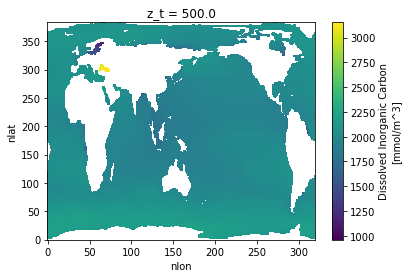

In [28]:
dsnoGCB.DIC.isel(z_t=0).plot()

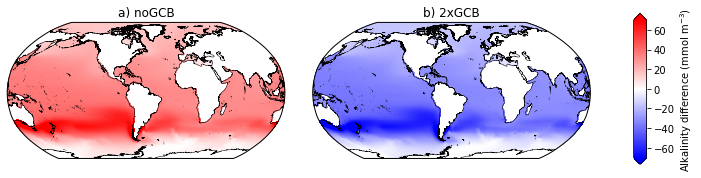

In [35]:
fig = plt.figure(figsize=(12,3))

######### Alk diff at surface layer for noGCB
lon,lat,field=adjust_pop_grid(lons, lats, Alk_diff_noGCB_surf)
ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) noGCB', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-70, vmax=70,transform=ccrs.PlateCarree())


######### Alk diff at 200 m
ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('b) 2xGCB', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, Alk_diff_2xGCB_surf, cmap='bwr',vmin=-70, vmax=70,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8,hspace=0,wspace=0.1)
cbar_ax = fig.add_axes([0.85, 0.16, 0.015, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,label='Alkalinity difference (mmol m$^{-3}$)',extend='both')

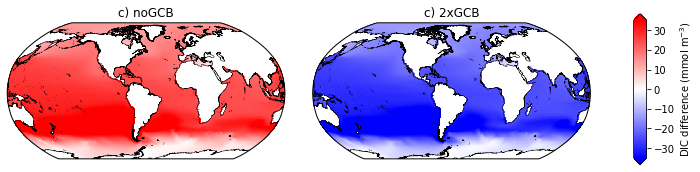

In [30]:
fig = plt.figure(figsize=(12,3))

######### DIC diff at surface layer for noGCB
ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('c) noGCB', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, DIC_diff_noGCB_surf, cmap='bwr',vmin=-35, vmax=35,transform=ccrs.PlateCarree())


######### DIC diff at 200 m
ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('c) 2xGCB', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, DIC_diff_2xGCB_surf, cmap='bwr',vmin=-35, vmax=35,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8,hspace=0,wspace=0.1)
cbar_ax = fig.add_axes([0.85, 0.16, 0.015, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,label='DIC difference (mmol m$^{-3}$)',extend='both')

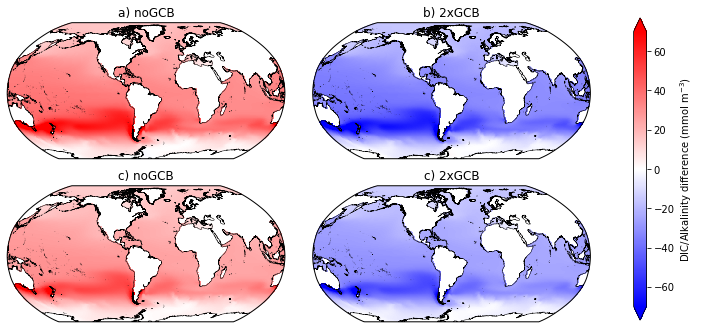

In [36]:
fig = plt.figure(figsize=(12,6))

######### Alk diff at surface layer for noGCB
lon,lat,field=adjust_pop_grid(lons, lats, Alk_diff_noGCB_surf)
ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) noGCB', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-70, vmax=70,transform=ccrs.PlateCarree())


######### Alk diff at surface for 2x GCB
lon,lat,field=adjust_pop_grid(lons, lats, Alk_diff_2xGCB_surf)
ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('b) 2xGCB', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-70, vmax=70,transform=ccrs.PlateCarree())


######### DIC diff at surface layer for noGCB
lon,lat,field=adjust_pop_grid(lons, lats, DIC_diff_noGCB_surf)
ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('c) noGCB', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-70, vmax=70,transform=ccrs.PlateCarree())


######### DIC diff at surface for 2x GCB
lon,lat,field=adjust_pop_grid(lons, lats, DIC_diff_2xGCB_surf)
ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('c) 2xGCB', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-70, vmax=70,transform=ccrs.PlateCarree())





fig.subplots_adjust(right=0.8,hspace=0,wspace=0.1)
cbar_ax = fig.add_axes([0.85, 0.16, 0.015, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,label='DIC/Alkalinity difference (mmol m$^{-3}$)',extend='both')

fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/DIC_ALK_surf_diffmaps.png', bbox_inches='tight', format='png', dpi=600);

### Isopycnals

#### Define 3D interpolation function

In [58]:
def interp3d(coord_field,ds,new_levels,dim,**kwargs):
    '''kludged function for interpolation
    '''

    method = kwargs.pop('method','linear')
    if method == 'linear':
        from metpy.interpolate import interpolate_1d
        interp_func = interpolate_1d
    elif method == 'log':
        from metpy.interpolate import log_interpolate_1d
        interp_func = log_interpolate_1d

    newdim = new_levels.dims[0]

    dso = xr.Dataset()
    for v in ds.variables:

        if dim not in ds[v].dims:
            dso[v] = ds[v]
        else:

            dims_in = ds[v].dims
            if len(dims_in) == 1: continue

            interp_axis = dims_in.index(dim)
            dims_out = list(dims_in)
            dims_out[interp_axis] = newdim

            dso[v] = xr.DataArray(
                interp_func(new_levels.values,
                            coord_field.values,ds[v].values,axis=interp_axis),
                dims=dims_out,attrs=ds[v].attrs)
    dso[newdim] = new_levels
    return dso

#### Put data on sigma coords

In [59]:
na = np.newaxis
pressure = sw.eos80.pres(depths.values[:,na,na],ds_woa.TLAT.values[:,:])

In [60]:
pressure.shape

(60, 384, 320)

In [61]:
pDensity = sw.pden(cesm_ann_ds.SALT, cesm_ann_ds.TEMP, pressure)-1000.

In [62]:
cesm_ann_ds['pdens'] = xr.DataArray(pDensity,dims=('z_t','nlat','nlon'))

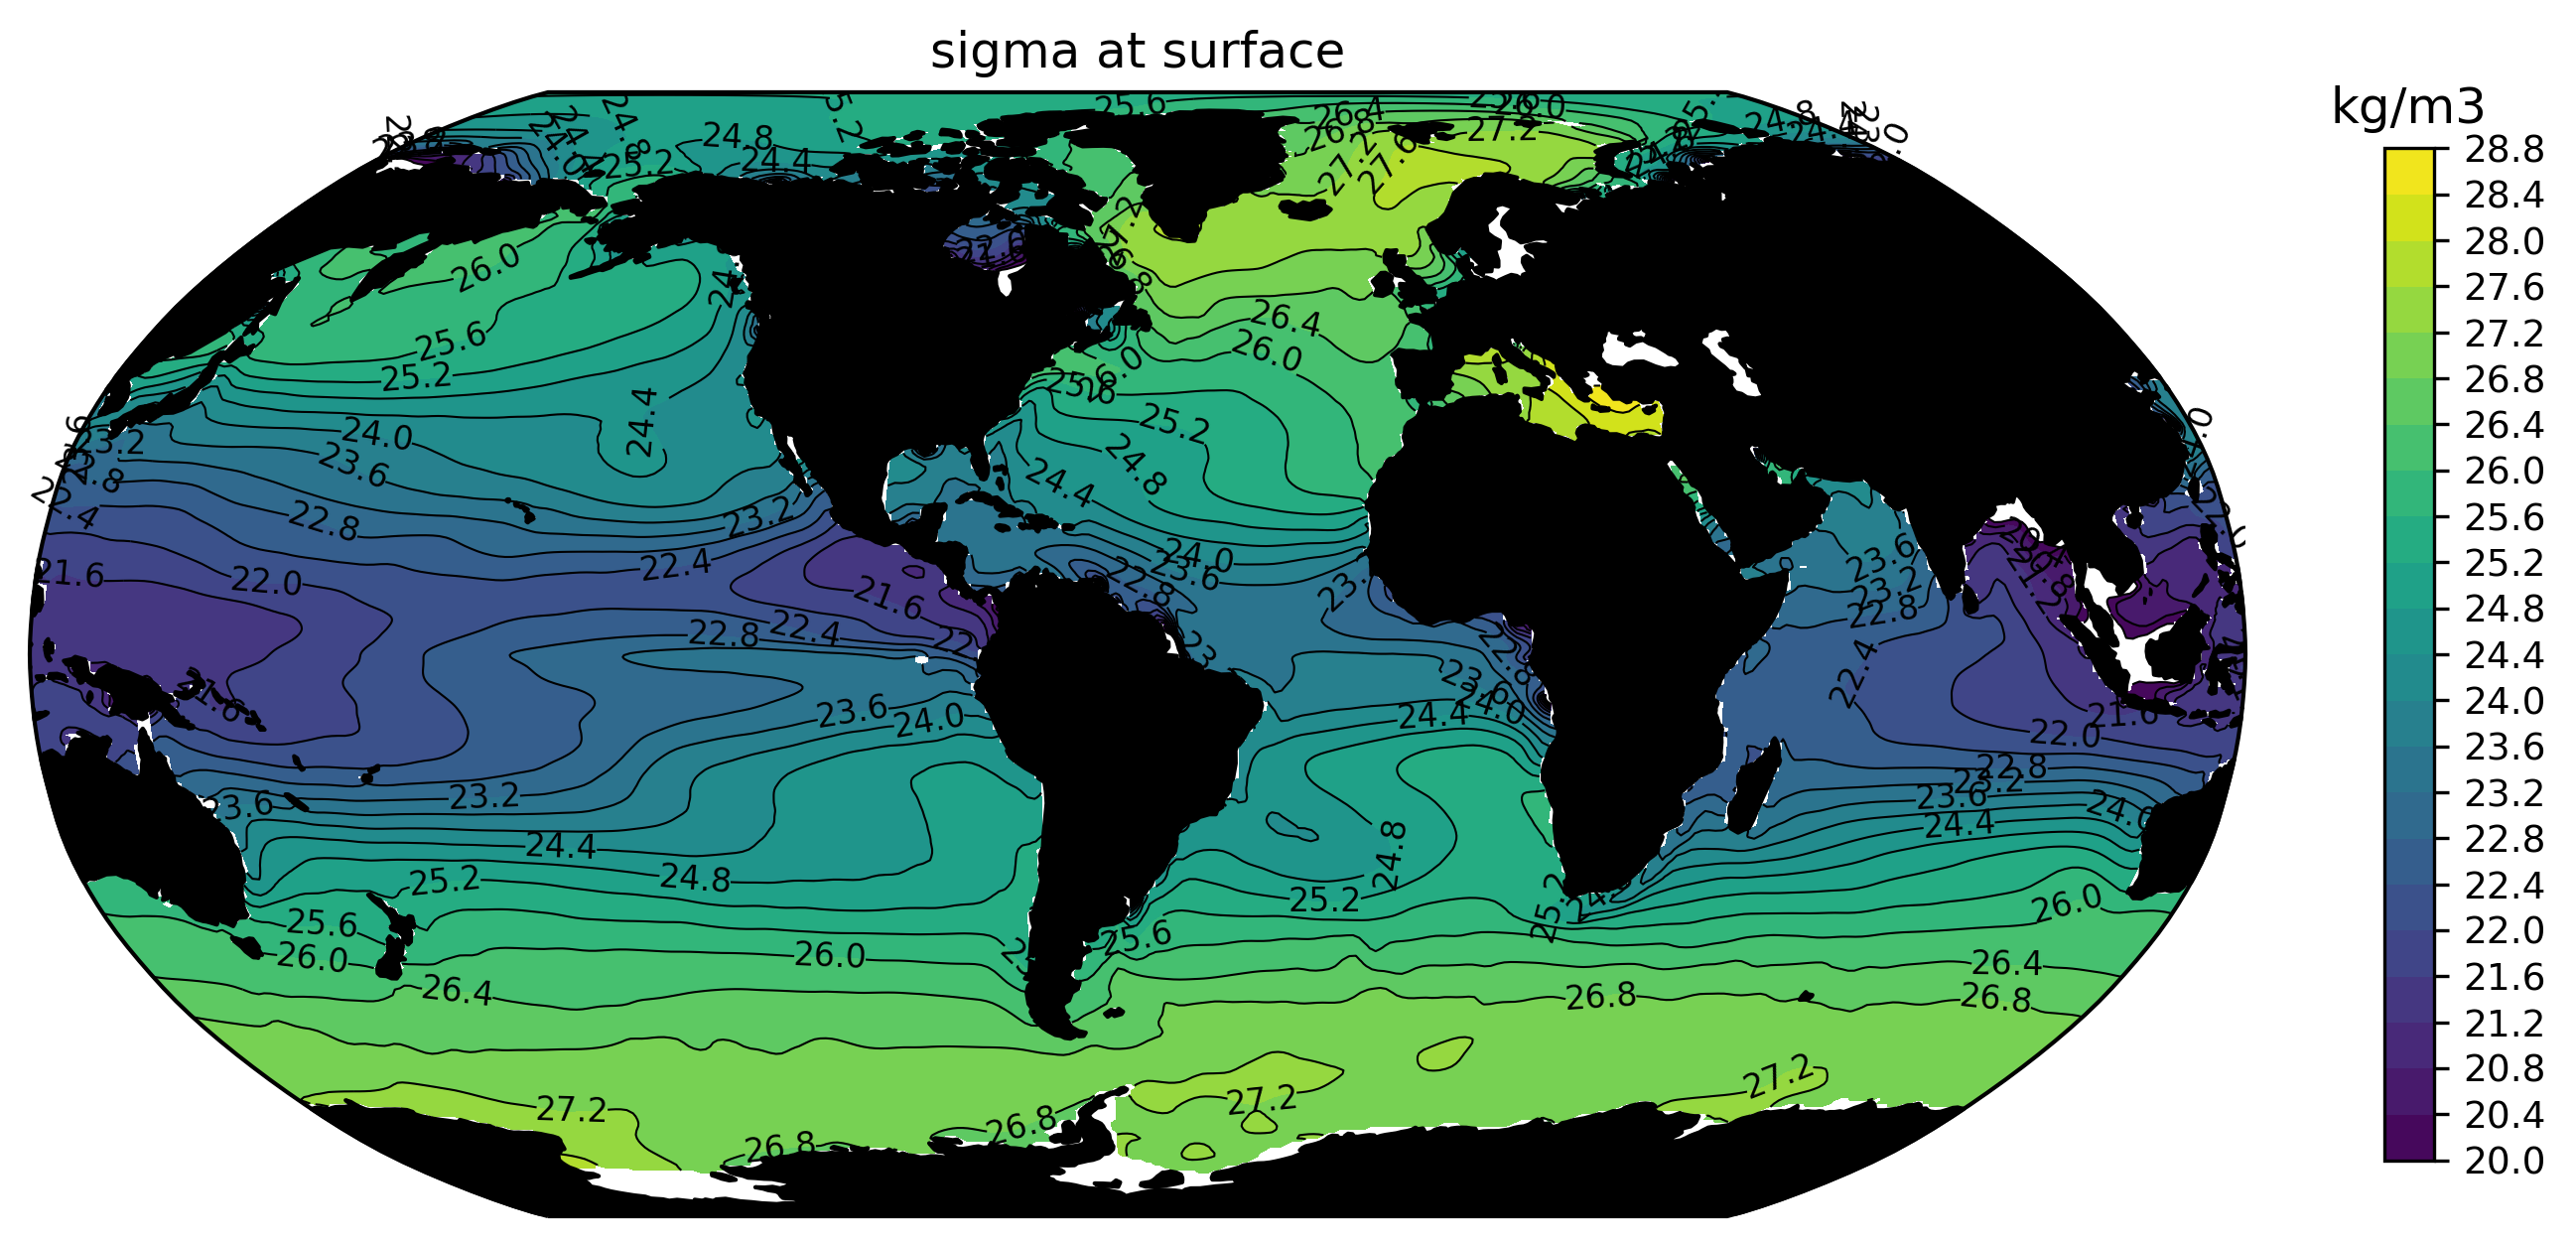

In [63]:
m={}
units = 'kg/m3'
plot_name = 'sigma at surface'
var='sigma'
field = cesm_ann_ds.pdens.isel(z_t=0)
lon,lat,field = adjust_pop_grid(lons,lats,field)

contour_specs = {'levels': np.around(np.arange(20., 29., 0.4),decimals=1)}
fig=plt.figure(figsize=(12, 6),dpi=300)
gs = gridspec.GridSpec(1,1)

m[var] = canvas_map_contour_overlay(lon,lat,field,
                                    contour_specs,
                                    units = units,
                                    fig=fig,
                                    gridspec=gs,
                                    row=0,col=0)
m[var]['ax'].set_title(plot_name);

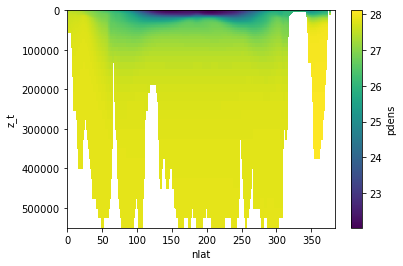

In [64]:
#zonal slice
sigma_Pacific = cesm_ann_ds.pdens.isel(nlon=200)
sigma_Pacific.plot(yincrease=False)

In [65]:
np.arange(21., 29., 0.2)

array([21. , 21.2, 21.4, 21.6, 21.8, 22. , 22.2, 22.4, 22.6, 22.8, 23. ,
       23.2, 23.4, 23.6, 23.8, 24. , 24.2, 24.4, 24.6, 24.8, 25. , 25.2,
       25.4, 25.6, 25.8, 26. , 26.2, 26.4, 26.6, 26.8, 27. , 27.2, 27.4,
       27.6, 27.8, 28. , 28.2, 28.4, 28.6, 28.8])

In [66]:
#sigma_coord = xr.DataArray(np.array([25.0,25.2,25.4,25.6,25.8,26.0,26.2,26.4,26.6,26.8,27.0,27.2]),dims='sigma')
sigma_coord = xr.DataArray(np.arange(21., 29., 0.2),dims='sigma')
ds_sigma_cesm = interp3d(cesm_ann_ds.pdens, cesm_ann_ds, sigma_coord, 'z_t', method='linear')

In [67]:
ds_sigma_cesm

<xarray.Dataset>
Dimensions:      (d2: 2, nlat: 384, nlon: 320, sigma: 40, z_t_150m: 15)
Coordinates:
  * z_t_150m     (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * sigma        (sigma) float64 21.0 21.2 21.4 21.6 ... 28.2 28.4 28.6 28.8
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound   (d2) float64 ...
    TLONG        (nlat, nlon) float64 ...
    TLAT         (nlat, nlon) float64 ...
    KMT          (nlat, nlon) float64 ...
    TAREA        (nlat, nlon) float64 ...
    TEMP         (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    SALT         (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    NO3          (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    ALK          (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    ALK_ALT_CO2  (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    coccoCaCO3   (z_t_150m, nlat, nlon) float32 ...
    pdens        (sigma

In [68]:
ds_sigma_cesm.sigma[29]

<xarray.DataArray 'sigma' ()>
array(26.8)
Coordinates:
    sigma    float64 26.8

In [69]:
#diff_268 = ds_sigma_cesm.ALK.sel(sigma=26.8) - ds_sigma_cesm.ALK_ALT_CO2.sel(sigma=26.8)
diff_268 = ds_sigma_cesm.ALK_ALT_CO2.isel(sigma=29) - ds_sigma_cesm.ALK.isel(sigma=29)

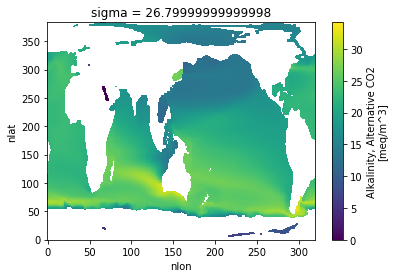

In [70]:
diff_268.plot();

In [71]:
ds_sigma_cesm.sigma[30]

<xarray.DataArray 'sigma' ()>
array(27.)
Coordinates:
    sigma    float64 27.0

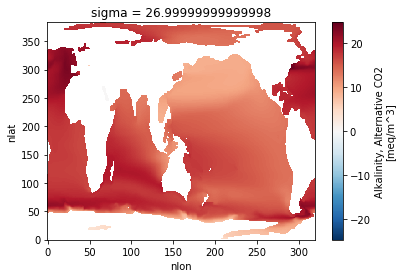

In [72]:
diff_270 = ds_sigma_cesm.ALK_ALT_CO2.isel(sigma=30) - ds_sigma_cesm.ALK.isel(sigma=30)
diff_270.plot();

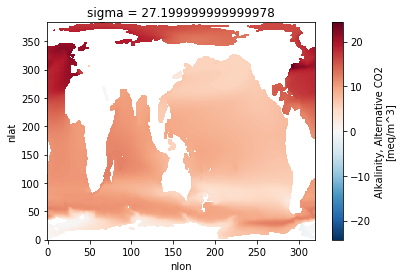

In [73]:
diff_272 = ds_sigma_cesm.ALK_ALT_CO2.isel(sigma=31) - ds_sigma_cesm.ALK.isel(sigma=31)
diff_272.plot();

In [74]:
ds_sigma_cesm.sigma[32]

<xarray.DataArray 'sigma' ()>
array(27.4)
Coordinates:
    sigma    float64 27.4

In [75]:
diff_274 = ds_sigma_cesm.ALK_ALT_CO2.isel(sigma=32) - ds_sigma_cesm.ALK.isel(sigma=32)

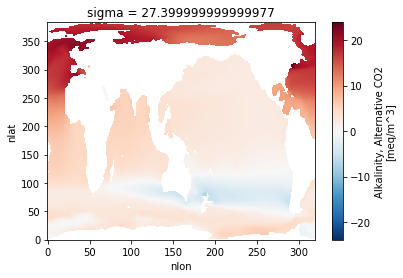

In [76]:
diff_274.plot();

In [77]:
ds_sigma_cesm.sigma[33]

<xarray.DataArray 'sigma' ()>
array(27.6)
Coordinates:
    sigma    float64 27.6

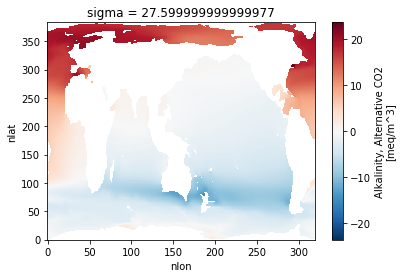

In [78]:
diff_276 = ds_sigma_cesm.ALK_ALT_CO2.isel(sigma=33) - ds_sigma_cesm.ALK.isel(sigma=33)
diff_276.plot()

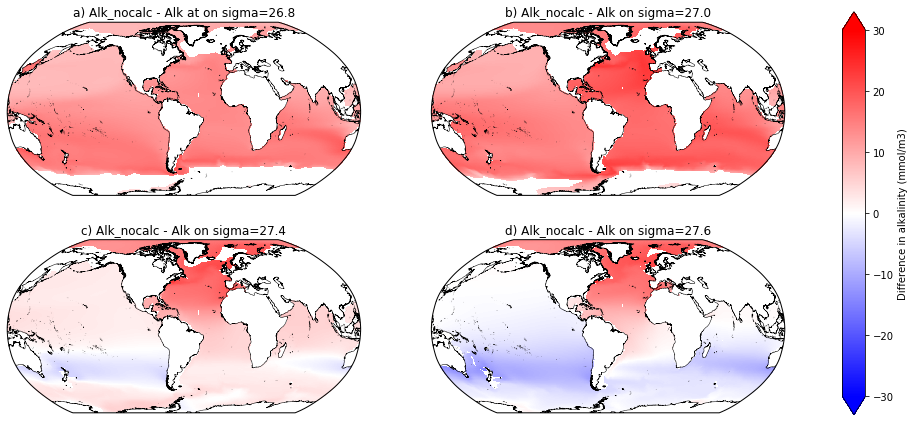

In [79]:
fig = plt.figure(figsize=(16,8))

######### Alk diff at surface layer
ax = fig.add_subplot(2,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) Alk_nocalc - Alk at on sigma=26.8', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, diff_268, cmap='bwr',vmin=-50, vmax=50,transform=ccrs.PlateCarree())


######### Alk diff at 200 m
ax = fig.add_subplot(2,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('b) Alk_nocalc - Alk on sigma=27.0', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, diff_270, cmap='bwr',vmin=-30, vmax=30,transform=ccrs.PlateCarree())

######### Alk diff at 482 m
ax = fig.add_subplot(2,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('c) Alk_nocalc - Alk on sigma=27.4', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, diff_274, cmap='bwr',vmin=-30, vmax=30,transform=ccrs.PlateCarree())

######### Alk diff at 787 m
ax = fig.add_subplot(2,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('d) Alk_nocalc - Alk on sigma=27.6', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, diff_276, cmap='bwr',vmin=-30, vmax=30,transform=ccrs.PlateCarree())



fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.16, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,label='Difference in alkalinity (mmol/m3)',extend='both')

In [80]:
def canvas_map_contour_overlay(lon,lat,z,
                               contour_specs,
                               units,
                               fig,
                               gridspec,
                               row,col):
    #-- make masked
    z = np.ma.masked_invalid(z)
    
    #-- make canvas
    ax = fig.add_subplot(gridspec[row,col],projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_global()

    #-- make filled contours
    cf = ax.contourf(lon,lat,z,
                     transform=ccrs.PlateCarree(),cmap='bwr',
                     **contour_specs)
    #-- rasterize
    zorder = 0
    for contour_level in cf.collections:
        contour_level.set_zorder(zorder)
        contour_level.set_rasterized(True)

    #-- add contour lines
    cs = ax.contour(lon,lat,z,
                    colors='k',
                    levels = contour_specs['levels'],
                    linewidths = 0.5,
                    transform=ccrs.PlateCarree(),
                    zorder=len(cf.collections)+10)
    fmt = '%r'
    #-- add contour labels
    lb = plt.clabel(cs, fontsize=8,
                   inline = True,
                   fmt=fmt)

    #-- add land mask
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                            edgecolor='face',
                                            facecolor='black'))

#     #-- add colorbar
#     i = 0
#     while True:
#         i += 1
#         try:
#             gridspec[i]
#         except:
#             break
#     len_gs = i
#     if len_gs == 1:
#         shrink_factor = 0.75
#     else:
#         shrink_factor = 0.75

#     cb = fig.colorbar(cf,ax = ax,
#                       ticks = contour_specs['levels'],
#                       orientation = 'vertical',
#                       shrink = shrink_factor)
#     cb.ax.set_title(units)
#     cb.ax.tick_params(labelsize=9) 
    cb=0
    return {'ax':ax,'cf':cf,'cs':cs,'lb':lb,'cb':cb}

In [81]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [2]:
levels=np.arange(-36,37,2)
levels

NameError: name 'np' is not defined

In [1]:


contour_specs = {'levels': levels}
fig=plt.figure(figsize=(12, 6),dpi=300)
gs = gridspec.GridSpec(2,2)
######### Alk diff atsigma=26.8

field = diff_268
lon,lat,field = adjust_pop_grid(lons,lats,field)

m = canvas_map_contour_overlay(lon,lat,field,
                                    contour_specs,
                                    units = units,
                                    fig=fig,
                                    gridspec=gs,
                                     row=0,col=0)
m['ax'].set_title('a) Alk_nocalc - Alk at on sigma=26.8', fontsize=12)

# ######### Alk diff at sigma=27.0
field = diff_270
lon,lat,field = adjust_pop_grid(lons,lats,field)

m = canvas_map_contour_overlay(lon,lat,field,
                                    contour_specs,
                                    units = units,
                                    fig=fig,
                                    gridspec=gs,
                                     row=0,col=1)
m['ax'].set_title('b) Alk_nocalc - Alk at on sigma=27.0', fontsize=12)

# ######### Alk diff at 482 m
field = diff_274
lon,lat,field = adjust_pop_grid(lons,lats,field)

m = canvas_map_contour_overlay(lon,lat,field,
                                    contour_specs,
                                    units = units,
                                    fig=fig,
                                    gridspec=gs,
                                     row=1,col=0)
m['ax'].set_title('c) Alk_nocalc - Alk at on sigma=27.4', fontsize=12)

# ######### Alk diff at 787 m
field = diff_276
lon,lat,field = adjust_pop_grid(lons,lats,field)

m = canvas_map_contour_overlay(lon,lat,field,
                                    contour_specs,
                                    units = units,
                                    fig=fig,
                                    gridspec=gs,
                                     row=1,col=1)
m['ax'].set_title('d) Alk_nocalc - Alk at on sigma=27.6', fontsize=12)


fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.16, 0.02, 0.7])
cbar = fig.colorbar(m['cf'],cax=cbar_ax,label='Difference in alkalinity (mmol/m3)')
fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/Alk_diffmaps_on_sigma.png', bbox_inches='tight', dpi=600);

NameError: name 'levels' is not defined

In [ ]:
fig = plt.figure(figsize=(16,16))

######### Alk diff at surface layer
ax = fig.add_subplot(4,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) Alk_nocalc - Alk at surface (5m)', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, diff_surf, cmap='bwr',vmin=-70, vmax=70,transform=ccrs.PlateCarree())


######### Alk diff at 200 m
ax = fig.add_subplot(4,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('b) Alk_nocalc - Alk 200m', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, diff_200m, cmap='bwr',vmin=-70, vmax=70,transform=ccrs.PlateCarree())

######### Alk diff at 482 m
ax = fig.add_subplot(4,2,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('c) Alk_nocalc - Alk 483m', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, diff_483m, cmap='bwr',vmin=-40, vmax=40,transform=ccrs.PlateCarree())

######### Alk diff at 787 m
ax = fig.add_subplot(4,2,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('d) Alk_nocalc - Alk 787m', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, diff_787m, cmap='bwr',vmin=-40, vmax=40,transform=ccrs.PlateCarree())


######### Alk diff at 1400 m
ax = fig.add_subplot(4,2,5, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('e) Alk_nocalc - Alk 1400m', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, diff_1400m, cmap='bwr',vmin=-40, vmax=40,transform=ccrs.PlateCarree())

######### Alk diff at 1967 m
ax = fig.add_subplot(4,2,6, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('f) Alk_nocalc - Alk 1967m', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, diff_1967m, cmap='bwr',vmin=-40, vmax=40,transform=ccrs.PlateCarree())

######### Alk diff at 2889 m
ax = fig.add_subplot(4,2,7, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('g) Alk_nocalc - Alk 2889m', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, diff_2889m, cmap='bwr',vmin=-40, vmax=40,transform=ccrs.PlateCarree())

######### Alk diff at 4375 m
ax = fig.add_subplot(4,2,8, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('g) Alk_nocalc - Alk 4375m', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lons, lats, diff_4375m, cmap='bwr',vmin=-40, vmax=40,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8,hspace=0)
cbar_ax = fig.add_axes([0.85, 0.16, 0.015, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,label='Difference in alkalinity (mmol/m3)',extend='both')